In [1]:
from tensorflow import keras
from collections import deque
import random
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output


In [2]:
class SudokuAgent:
    def __init__(self):
        self.state_size = 9*9
        self.action_size = 9*9*9
        self.memory = deque(maxlen=5000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.005
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = keras.Sequential()
        model.add(keras.layers.Dense(48, input_dim=self.state_size, activation='relu'))
        model.add(keras.layers.Dense(48, activation='relu'))
        model.add(keras.layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(lr=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def test_act(self, state):
        """
        For testing the current performance of the model without any random actions
        """
        return np.argmax(self.model.predict(state)[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target 
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [3]:
import gym
import gym_sudoku
import numpy as np 
import helper
import time

num_let_map = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

env = gym.make('Sudoku-v0')
test_env = gym.make('Sudoku-v0') # Making a copy to not have to worry about overwriting puzzles during testing
puzzles = np.load('puzzles.npy')

# This is how we pass in the puzzle to be solved
env.base = puzzles[0][0] # Unfinished puzzle
env.sol = puzzles[0][1]  # Solution (used to inform reward function)

# Needed to initialize
env.reset()

#env.render()

agent = SudokuAgent()


In [4]:
def plot_metrics(tr_s, tr_f, ts, ep, testing=False):
    # Average reward per episode for solved vs unsolved training data
    plt.figure()
    plt.plot(tr_s['epsilon'], tr_s['avg_reward'], 'o', label='solved')
    plt.plot(tr_f['epsilon'], tr_f['avg_reward'], 'o', label='unsolved')
    plt.xlabel('Epsilon (Exploration Rate)')
    plt.ylabel('Avg Reward')
    plt.title('Epsilon vs. avg reward over ' + str(ep) + ' episodes')
    plt.grid(True)
    plt.legend()
    
    # Total reward per episode for solved vs unsolved training data
    plt.figure()
    plt.plot(tr_s['epsilon'], tr_s['reward'], 'o', label='solved')
    plt.plot(tr_f['epsilon'], tr_f['reward'], 'o', label='unsolved')
    plt.xlabel('Epsilon (Exploration Rate)')
    plt.ylabel('Reward')
    plt.title('Epsilon vs. Total reward over ' + str(ep) + ' episodes')
    plt.grid(True)
    plt.legend()
    
    plt.figure()
    plt.plot(tr_s['epsilon'], tr_s['num_iters'], 'o', label='solved')
    plt.plot(tr_f['epsilon'], tr_f['num_iters'], 'o', label='unsolved')
    plt.xlabel('Epsilon (Exploration Rate)')
    plt.ylabel('# of Iterations')
    plt.title('Epsilon vs. Number of iterations/episode in ' + str(ep) + ' episodes')
    plt.grid(True)
    plt.legend()
    
    if ((testing is True) and (len(ts) > 1)):
        plt.figure()
        plt.plot(ts.index + 1, ts['avg_reward'], 'o', label='average reward')
        plt.xlabel('Test #')
        plt.ylabel('Average rewards')
        plt.title('Test # vs. Average Rewards for ' + str(len(ts)) + ' test runs')
        plt.grid(True)
        plt.legend()
    
    plt.show()

In [5]:
def arr_index_to_action(index):
    """
    Maps an index 0-728 to an action: eg, put 3 in row 5, col 2
    The index will be the output of the NN's predict function because it takes an
    argmax of 729 layers
    """
    
    num_to_fill = index//81 # dont need to +1 here because it is done in the sudoku env source code
    
    flattened_index = index - index//81 * 81
    row = flattened_index//9
    col = flattened_index - row * 9
    
    return [row, col, num_to_fill]

def get_init_states_index(grid):
    """
    Given a starting sudoku board (2d numpy array), get the indices of the grids that are non-zero.
    You want to heavily penalize these grids because the agent is not supposed to change it at all
    """
    m = np.nonzero(grid)
    return list(zip(m[0],m[1]))
    

No legal moves remaining for puzzle # 166
episode: 166/300
finished ep 166 with average reward -9.117890, epsilon=0.432967


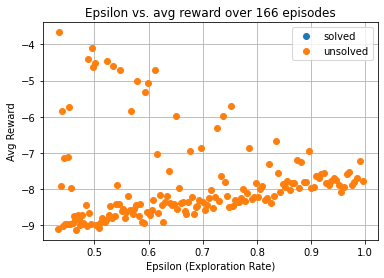

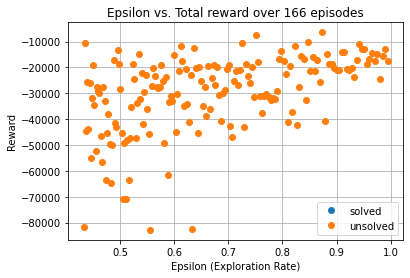

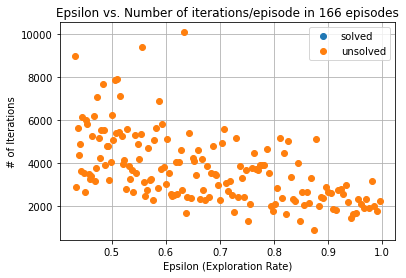

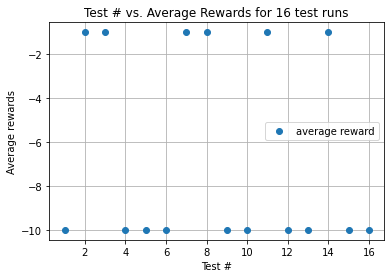

Current episode: 167


In [ ]:
# Iterate the game
episodes = 300
num_timesteps = 5000

is_done = True
puzz_counter = 0

# Metrics to track per episode
enable_tests = True
test_freq = 10      # Evaluate model performance on every n_th puzzle
train_metrics = []
test_metrics = []

for e in range(episodes):
    print('Current episode: %d' % e)
    
    clear_output(wait=True)

    if is_done:
        env.base = puzzles[puzz_counter][0] # Unfinished puzzle
        env.sol = puzzles[puzz_counter][1]  # Solution (used to inform reward function)
        init_states_index = get_init_states_index(puzzles[puzz_counter][0])
        env.init_states_index = init_states_index
        env.verbose = False
        
        puzz_counter += 1
        is_done = False
    
    # reset state in the beginning of each game
    state = env.reset()
    
    # rows is the number of training examples, cols are the training features
    # state = np.reshape(state, [1, -1])
    reward_for_ep = 0
    
    num_iters = 0
    while True:
        # turn this on if you want to render
        # env.render()
        
        # Decide action
        action_index_flat = agent.act(state.reshape(1,-1))
        action = arr_index_to_action(action_index_flat)

        # Advance the game to the next frame based on the action.
        next_state, reward, done, _ = env.step(action)
        reward_for_ep += reward

        #act_row = num_let_map[action[0]]
        #act_col = action[1] + 1 
        #act_val = action[2] + 1
        #print('Last action: [%s,%d] ==> %d, Reward: %d\n\n\n' % (act_row, act_col, act_val, reward))
        
        # memorize the previous state, action, reward, and done
        agent.memorize(state.reshape(1,-1), action_index_flat, reward, next_state.reshape(1,-1), done)

        # make next_state the new current state for the next frame.
        state = next_state
        
        # Check if the puzzle was completed
        
        is_solved = np.array_equal(env.sol, state)
        num_zeros = np.size(state) - np.count_nonzero(state)
        
        #print('Episode: %d, Num_iters: %d, Num elements remaining: %d' % (e, num_iters, num_zeros))


        #time.sleep(5)
        num_iters += 1
        
        if done:
            # print the score and break out of the loop
            if is_solved:
                print('Solved puzzle #: %d' % (puzz_counter-1))
            else:
                print('No legal moves remaining for puzzle # %d' % (puzz_counter-1))
            #env.render()
            
            print("episode: {}/{}".format(e, episodes))
            is_done = True
            break
        
    # train the agent with the experience of the episode
    if num_iters >= 63:
        agent.replay(64)
    else:
        agent.replay(num_iters-1)
  
    # Metrics tracking 
    train_metrics.append({'episode': e, 'reward': reward_for_ep, 'num_iters': num_iters,
                    'avg_reward': reward_for_ep/(num_iters), 'epsilon': agent.epsilon, 
                     'solved': is_solved, 'puzzle_num': puzz_counter-1})
        
    # TESTING CURRENT MODEL: 
    # Choose a puzzle randomly that was not seen up to now 

    if ((enable_tests is True) and (((e+1) % test_freq)==0)):
        test_puzz = np.random.randint(puzz_counter, 1000000) # Test randomly on a puzzle we haven't seen yet
        test_env.base = puzzles[test_puzz][0] # Unfinished puzzle
        test_env.sol = puzzles[test_puzz][1]  # Solution (used to inform reward function)
        test_env.init_states_index = get_init_states_index(puzzles[test_puzz][0])

        state = test_env.reset()
        test_reward_for_ep = 0
        test_solved = False
        
        test_num_iters = 0
        while True:
            action_index_flat = agent.test_act(state.reshape(1,-1)) # Use a different action function that acts using model
            action = arr_index_to_action(action_index_flat)

            next_state, reward, done, _ = test_env.step(action)
            test_reward_for_ep += reward
            
            state = next_state
            is_solved = np.array_equal(test_env.sol, state)
            
            test_num_iters += 1
            if ((done is True) or (test_num_iters > 5000)):
                if ((done is True) and (is_solved is True)):
                    print('Model solved puzzle #: %d' % (test_puzz))            
                elif ((done is True) and (is_solved is False)):
                    print('Model ran out of legal moves on puzzle #: %d' % (test_puzz))
                elif (done is False):
                    print('Model failed to solve puzzle %d in <5k steps!' % (test_puzz))
                    
                break
                
    
        test_metrics.append({'num_train_episodes': e, 'reward': test_reward_for_ep,
                              'num_iters': test_num_iters, 'avg_reward': test_reward_for_ep/(test_num_iters+1),
                              'solved': test_solved, 'puzzle_num': test_puzz})
        
    print("finished ep {:d} with average reward {:f}, epsilon={:f}".format(e,reward_for_ep/(num_iters+1), agent.epsilon))
    

    # Although its inefficient to re-create this every time, this df makes it easy to plot relevant metrics
    train = pd.DataFrame(train_metrics)
    test = pd.DataFrame(test_metrics)
    
    tr_solv = train.loc[train['solved'] == True]
    tr_fail = train.loc[train['solved'] == False]

    plot_metrics(tr_solv, tr_fail, test, e, enable_tests)